## Проверка данных Мисифримета

![Минсифримет](misiframet_s.jpg)

In [1]:
import pandas as pd
import numpy as np
import os
import sys
from datetime import datetime
from datetime import timedelta
import sqlite3
from tabulate import tabulate

# игнорирование предупреждения о формате при импорте из excel
import warnings

warnings.simplefilter("ignore")
# пути и списки файлов
# файлы берём непосредственно из хранилища нового бота посещений
e_path = "C:/work/new_bot/new/e"
s_path = "C:/work/new_bot/new/s"
dm_path = "C:/work/new_bot/new/dm"
vis_reg_ref_path = "C:/work/new_bot/new/vis_reg_ref.csv"
e_file_list = os.listdir(e_path)
s_file_list = os.listdir(s_path)
dm_file_last = os.listdir(dm_path + "/" + max(os.listdir(dm_path)))
# выгрузки ПОС
pos_path = "C:/work/pos_bot/POS"
pos_dir_last = os.listdir(pos_path + "/" + max(os.listdir(pos_path)))
pos_reg_ref_path = "/".join(pos_path.split("/")[:-1]) + "/pos_reg_ref.csv"

# типы ошибок
t_error_list = [
    "Ошибка валидации данных пациента",
    "Ошибка «РМИС не ответил»",
    "Внутренняя ошибка РМИС при создании записи",
    "Сервис МИС приостановлен",
    "Ошибка валидации схемы",
    "Время уже занято другим пациентом",
    "Услуга посмертно не оказывается",
    "Время начала приема уже прошло",
]
tdb_error_list = [
    "Ошибка валидации данных пациента",
    "Ошибка «РМИС не ответил»",
    "Внутренняя ошибка РМИС при создании записи",
    "Сервис МИС приостановлен",
    "Ошибка валидации схемы",
]
b_list = [
    "Пациент уже записан на это время к другому специалисту",
    "Пациент уже записан к специалисту в этот день",
    "Выбранное время доступно только для записи пациентов определенного возраста",
]
o_error_list = [
    "Значение не найдено",
]
r_error_list = [
    "Ошибка «СМЭВ-timeout»",
    "Внутренняя ошибка концентратора при создании записи",
    "Ошибка во входных параметрах при записи на прием",
]
any_error_list = [
    "Ошибка доставки формы при записи на прием",
    "Истекло время сессии пользователя",
    "Ошибка соответствия ответа запросу МИС",
]
draft_list = ["Ошибка отсутсвует"]
# словарь списков типов ошибок
e_type_dict = {
    "t": t_error_list,
    "tdb": tdb_error_list,
    "b": b_list,
    "o": o_error_list,
    "r": r_error_list,
    "any": any_error_list,
    "draft": draft_list,
}


def error_table(df):
    """функция принимает только (!) df_error_yesterday или df_error_today и возвращает df ошибок"""
    df_tmp_o = df[df["final_state"].isin(o_error_list)]
    df_tmp_o["type"] = "орг. дашборд"
    df_tmp_t = df[df["final_state"].isin(t_error_list)]
    df_tmp_t["type"] = "технические всего"
    df_tmp_tdb = df[df["final_state"].isin(tdb_error_list)]
    df_tmp_tdb["type"] = "технические дашборд"
    df_tmp_b = df[df["final_state"].isin(b_list)]
    df_tmp_b["type"] = "бизнес-правила"
    df_tmp_r = df[df["final_state"].isin(r_error_list)]
    df_tmp_r["type"] = "фэр дашборд"
    df_tmp_any = df[df["final_state"].isin(any_error_list)]
    df_tmp_any["type"] = "прочая"
    df_tmp_draft = df[df["final_state"].isin(draft_list)]
    df_tmp_draft["type"] = "прервано дашборд"
    df_error_type = pd.concat(
        [df_tmp_o, df_tmp_t, df_tmp_tdb, df_tmp_b, df_tmp_r, df_tmp_any, df_tmp_draft]
    ).reset_index(drop=True)
    df_error_type = (
        df_error_type.pivot_table(
            index="Название субъекта РФ",
            columns="type",
            values="session_id",
            aggfunc="count",
        )
        .reset_index()
        .fillna(0)
        .rename_axis(None, axis=1)
    )
    df_error_type = df_error_type.astype(
        {
            "бизнес-правила": "int",
            "орг. дашборд": "int",
            "прервано дашборд": "int",
            "технические всего": "int",
            "технические дашборд": "int",
            "фэр дашборд": "int",
        }
    )
    return df_error_type

def badsim(df, sim):
    """проверка на наличие в текстовых полях недопустимого символа"""
    print(f"Записи, содержащие '{sim}':")
    for col in df.columns.tolist():
        if df.dtypes[col] == "object":
            try:
                bad_str = df[df[col].str.contains(sim)][col].unique()
            except Exception as e:
                pass
            if len(bad_str) != 0:
                print(f"\tПОЛЕ: {col}")
                print(bad_str)

### Ошибки за последние даты

In [2]:
%%time
# ошибки записи (два последние файла)
m=0
for file_name in e_file_list[-2:]:
    if m == 0:
        file_name_for_error_count_yesterday = file_name
    else:
        file_name_for_error_count_today = file_name
    df_tmp = pd.read_csv(e_path + "/" + file_name, sep=";")
    print(f"\nФайл {file_name}:")
    print(f"\t\tвсего строк:\t\t\t{df_tmp.shape[0]}")
    cnt_c = "верно" if df_tmp.shape[1] == 13 else "ошибка"
    print(f"\t\tвсего столбцов:\t\t\t{df_tmp.shape[1]} ({cnt_c})")
    print("\tПропуски в столбцах, где их быть не должно:")
    df_nonan = df_tmp[
        [
            "session_id",
            "Название субъекта РФ",
            "step_id",
            "step_name",
            "error_code",
            "final_state",
            "create_ts",
            "Тип записи",
            "referral_flg",
        ]
    ]
    n = 0
    for column in df_nonan.columns:
        if df_nonan[column].isnull().sum() != 0:
            print(
                f"\t\tстолбец '{column}':\t\t {df_nonan[column].isnull().sum()} ({round(df_nonan[column].isnull().sum()*100/df_nonan.shape[0], 2)} %)"
            )
            n += 1
    if n == 0:
        print("\t\tотсутствуют")
    print(
        "\tОшибки данных (количество и доля от числа строк на соответствующем этапе):"
    )
    # число строк на соответствующих этапах
    len_ValidatePerson = df_tmp[df_tmp["step_name"] == "ValidatePerson"].shape[0]
    len_MO = df_tmp[df_tmp["step_name"] == "MO"].shape[0]
    len_ServiceOrSpecs = df_tmp[df_tmp["step_name"] == "ServiceOrSpecs"].shape[0]
    len_Slot = df_tmp[df_tmp["step_name"] == "Slot"].shape[0]
    len_Book = df_tmp[df_tmp["step_name"] == "Book"].shape[0]

    """
    На этапе валидации пациента
    есть данные oid МО
    ИЛИ есть данные о названии МО
    ИЛИ есть данные о специальности врача
    ИЛИ есть данные о слоте
    """
    df_ValidatePerson = df_tmp[
        (df_tmp["step_name"] == "ValidatePerson")
        & (
            df_tmp["mo_oid"].notnull()
            | df_tmp["mo_name"].notnull()
            | df_tmp["Post_name"].notnull()
            | df_tmp["slot_ts"].notnull()
        )
    ]
    """
    На этапе выбора МО
    есть данные oid МО
    ИЛИ есть данные о названии МО
    ИЛИ есть данные о специальности врача
    ИЛИ есть данные о слоте
    """
    df_MO = df_tmp[
        (df_tmp["step_name"] == "MO")
        & (
            df_tmp["mo_oid"].notnull()
            | df_tmp["mo_name"].notnull()
            | df_tmp["Post_name"].notnull()
            | df_tmp["slot_ts"].notnull()
        )
    ]
    """
    На этапе выбора специальности врача
    нет данных об oid МО
    ИЛИ нет данных о названии МО
    ИЛИ есть данные о специальности врача
    ИЛИ есть данные о слоте
    """
    df_ServiceOrSpecs = df_tmp[
        (df_tmp["step_name"] == "ServiceOrSpecs")
        & (
            ~df_tmp["mo_oid"].notnull()
            | ~df_tmp["mo_name"].notnull()
            | df_tmp["Post_name"].notnull()
            | df_tmp["slot_ts"].notnull()
        )
    ]
    """"
    На этапе выбора слота
    нет данных об oid МО
    ИЛИ нет данных о названии МО
    ИЛИ нет данных о специальтности врача
    ИЛИ есть данные о времени слота
    """
    df_Slot = df_tmp[
        (df_tmp["step_name"] == "Slot")
        & (
            ~df_tmp["mo_oid"].notnull()
            | ~df_tmp["mo_name"].notnull()
            | ~df_tmp["Post_name"].notnull()
            | df_tmp["slot_ts"].notnull()
        )
    ]
    """
    На этапе записи
    нет любых данных (ИЛИ)
    """
    df_Book = df_tmp[
        (df_tmp["step_name"] == "Book")
        & (
            ~df_tmp["mo_oid"].notnull()
            | ~df_tmp["mo_name"].notnull()
            | ~df_tmp["Post_name"].notnull()
            | ~df_tmp["slot_ts"].notnull()
        )
    ]

    if df_ValidatePerson.shape[0] >= 0:
        print(
            f"\t\tValidatePerson_uncorrected:\t{df_ValidatePerson.shape[0]}\t({round(df_ValidatePerson.shape[0]*100/len_ValidatePerson, 2)} %)"
        )
    if df_MO.shape[0] >= 0:
        print(
            f"\t\tMO_uncorrected:\t\t\t{df_MO.shape[0]}\t({round(df_MO.shape[0]*100/len_MO, 2)} %)"
        )
    if df_ServiceOrSpecs.shape[0] >= 0:
        print(
            f"\t\tServiceOrSpecs_uncorrected:\t{df_ServiceOrSpecs.shape[0]}\t({round(df_ServiceOrSpecs.shape[0]*100/len_ServiceOrSpecs, 2)} %)"
        )
    if df_Slot.shape[0] >= 0:
        print(
            f"\t\tSlot_uncorrected:\t\t{df_Slot.shape[0]}\t({round(df_Slot.shape[0]*100/len_Slot, 2)} %)"
        )
    if df_Book.shape[0] >= 0:
        print(
            f"\t\tBook_uncorrected:\t\t{df_Book.shape[0]}\t({round(df_Book.shape[0]*100/len_Book, 2)} %)"
        )
    if (
        df_ValidatePerson.shape[0]
        + df_MO.shape[0]
        + df_ServiceOrSpecs.shape[0]
        + df_Slot.shape[0]
        + df_Book.shape[0]
        == 0
    ):
        print("\t\tотсутствуют")

    # субъекты, которых нет на дашборде
    df_tmp_3 = df_tmp[df_tmp['Тип записи'] == 3]

    # данные для сравнительного расчёта
    if m == 0:
        df_error_yesterday = df_tmp_3.copy()
    else:
        df_error_today = df_tmp_3.copy()
    
    df_nosub = df_tmp_3[
        (df_tmp["Название субъекта РФ"] == "Федеральное медико-биологическое агентство")
        | (df_tmp["Название субъекта РФ"] == "г. Байконур")
    ][["Название субъекта РФ", "final_state"]]
    df_nosub["value"] = 1
    # ошибки, которых нет на дашборде
    df_nosub_e = (
        df_nosub.groupby(["Название субъекта РФ", "final_state"])
        .sum()
        .reset_index()[["final_state", "value"]]
    )
    no_db_e_dict = {}
    for key, value in e_type_dict.items():
        no_db_e_dict[str(key + "_ndb")] = df_nosub_e[
            df_nosub_e["final_state"].isin(value)
        ]["value"].sum()

    df_errors = pd.DataFrame(
        df_tmp[df_tmp["Тип записи"] == 3].groupby("final_state")["session_id"].count()
    ).reset_index()
    print('\tКоличество ошибок записи на приём (тип записи "К врачу"; рассылка (дашборд)):')
    o_e = df_errors[df_errors["final_state"].isin(o_error_list)]["session_id"].sum()
    print(f'\t\tорганизационные ошибки:\t\t{o_e}\t({o_e - no_db_e_dict["o_ndb"]})')
    t_e = df_errors[df_errors["final_state"].isin(t_error_list)]["session_id"].sum()
    t_e_db = (
        df_errors[df_errors["final_state"].isin(tdb_error_list)]["session_id"].sum()
        - no_db_e_dict["tdb_ndb"] # было t_ndb
    )
    print(f"\t\tтехнические ошибки:\t\t{t_e}\t({t_e_db})")
    any_e = df_errors[df_errors["final_state"].isin(any_error_list)]["session_id"].sum()
    any_e_ndb = any_e - no_db_e_dict["any_ndb"]
    print(f"\t\tтехнические ошибки с 'прочими':\t{t_e + any_e}\t({t_e_db + any_e_ndb})")
    r_e = df_errors[df_errors["final_state"].isin(r_error_list)]["session_id"].sum()
    print(f'\t\tошибки ФЭР:\t\t\t{r_e}\t({r_e - no_db_e_dict["r_ndb"]})')
    # any_e = df_errors[df_errors["final_state"].isin(any_error_list)]["session_id"].sum()
    print(f'\t\tпрочие ошибки:\t\t\t{any_e}\t({any_e - no_db_e_dict["any_ndb"]})')
    draft = df_errors[df_errors["final_state"].isin(draft_list)]["session_id"].sum()
    print(f'\t\tчерновики:\t\t\t{draft}\t({draft - no_db_e_dict["draft_ndb"]})')
    b = df_errors[df_errors["final_state"].isin(b_list)]["session_id"].sum()
    print(f'\t\tбизнес-правила:\t\t\t{b}\t({b - no_db_e_dict["b_ndb"]})')
    print("\tСубъекты, не отображаемые на дашборде:")
    if df_nosub.empty:
        print("\t\tотсутствуют")
    else:
        print(
            df_nosub.groupby(["Название субъекта РФ", "final_state"])
            .sum()
            .reset_index()
            .to_string(index=False)
        )
    m+=1
badsim(df_error_yesterday, "_")
badsim(df_error_today, "_")
print("-----------------------------------------------------------------------------------------------")
print(f"Вчерашний файл:\t\t{file_name_for_error_count_yesterday}")
print(f"Актуальный файл:\t{file_name_for_error_count_today}")
print("-----------------------------------------------------------------------------------------------")
    # break


Файл 05.08.2024.csv:
		всего строк:			642814
		всего столбцов:			13 (верно)
	Пропуски в столбцах, где их быть не должно:
		отсутствуют
	Ошибки данных (количество и доля от числа строк на соответствующем этапе):
		ValidatePerson_uncorrected:	0	(0.0 %)
		MO_uncorrected:			0	(0.0 %)
		ServiceOrSpecs_uncorrected:	2810	(2.05 %)
		Slot_uncorrected:		2613	(1.8 %)
		Book_uncorrected:		347	(1.98 %)
	Количество ошибок записи на приём (тип записи "К врачу"; рассылка (дашборд)):
		организационные ошибки:		62696	(62615)
		технические ошибки:		67879	(66802)
		технические ошибки с 'прочими':	67879	(66802)
		ошибки ФЭР:			35490	(35481)
		прочие ошибки:			0	(0)
		черновики:			461596	(461430)
		бизнес-правила:			13744	(13730)
	Субъекты, не отображаемые на дашборде:
                      Название субъекта РФ                                      final_state  value
Федеральное медико-биологическое агентство       Внутренняя ошибка РМИС при создании записи      1
Федеральное медико-биологическое агентство 

#### Ошибки по регионам на последнюю дату

In [3]:
print(f"Файл: {file_name_for_error_count_today}")
error_table(df_error_today)

Файл: 26.06.2024.csv


,Название субъекта РФ,бизнес-правила,орг. дашборд,прервано дашборд,технические всего,технические дашборд,фэр дашборд
0,Алтайский край,17,186,15964,140,140,566
1,Амурская область,94,4,2148,116,105,21
2,Архангельская область,54,833,13528,250,216,723
3,Астраханская область,2,4,23,3,3,0
4,Белгородская область,232,86,3645,500,496,644
...,...,...,...,...,...,...,...
81,Ямало-Ненецкий автономный округ,0,0,0,1,1,0
82,Ярославская область,69,1181,2263,508,499,458
83,г. Москва,0,448,6308,3623,3623,95
84,г. Санкт-Петербург,207,749,8274,478,459,1427


#### Сравнение ошибок "вчера-сегодня"

In [11]:
df_e_y = error_table(df_error_yesterday)
df_e_t = error_table(df_error_today)
df_e_yt = df_e_t.merge(df_e_y, on="Название субъекта РФ", how="outer").fillna(0)
df_e_yt = df_e_yt.rename(
    columns={
        "бизнес-правила_x": "бп отч",
        "орг. дашборд_x": "оДБ отч",
        "прервано дашборд_x": "чДБ отч",
        "технические всего_x": "т отч",
        "технические дашборд_x": "тДБ отч",
        "фэр дашборд_x": "фДБ отч",
        "бизнес-правила_y": "бп прш",
        "орг. дашборд_y": "оДБ прш",
        "прервано дашборд_y": "чДБ прш",
        "технические всего_y": "т прш",
        "технические дашборд_y": "тДБ прш",
        "фэр дашборд_y": "фДБ прш",
    }
)
df_e_yt = df_e_yt.astype(
    {
        "бп отч": "int",
        "оДБ отч": "int",
        "чДБ отч": "int",
        "т отч": "int",
        "тДБ отч": "int",
        "фДБ отч": "int",
        "бп прш": "int",
        "оДБ прш": "int",
        "чДБ прш": "int",
        "т прш": "int",
        "тДБ прш": "int",
        "фДБ прш": "int",
    }
)
df_e_yt = df_e_yt[
    [
        "Название субъекта РФ",
        "бп отч",
        "бп прш",
        "оДБ отч",
        "оДБ прш",
        "чДБ отч",
        "чДБ прш",
        "т отч",
        "т прш",
        "тДБ отч",
        "тДБ прш",
        "фДБ отч",
        "фДБ прш",
    ]
]
df_e_yt.insert(3, "Δбп", df_e_yt["бп отч"] - df_e_yt["бп прш"])
df_e_yt.insert(6, "ΔоДБ", df_e_yt["оДБ отч"] - df_e_yt["оДБ прш"])
df_e_yt.insert(9, "ΔчДБ", df_e_yt["чДБ отч"] - df_e_yt["чДБ прш"])
df_e_yt.insert(12, "Δт", df_e_yt["т отч"] - df_e_yt["т прш"])
df_e_yt.insert(15, "ΔтДБ", df_e_yt["тДБ отч"] - df_e_yt["тДБ прш"])
df_e_yt["ΔфДБ"] = df_e_yt["фДБ отч"] - df_e_yt["фДБ прш"]

df_e_yt

,Название субъекта РФ,бп отч,бп прш,Δбп,оДБ отч,оДБ прш,ΔоДБ,чДБ отч,чДБ прш,ΔчДБ,т отч,т прш,Δт,тДБ отч,тДБ прш,ΔтДБ,фДБ отч,фДБ прш,ΔфДБ
0,Алтайский край,17,17,0,186,186,0,15964,16820,-856,140,1218,-1078,140,1218,-1078,566,625,-59
1,Амурская область,94,87,7,4,12,-8,2148,2291,-143,116,209,-93,105,196,-91,21,21,0
2,Архангельская область,54,52,2,833,1005,-172,13528,14271,-743,250,302,-52,216,268,-52,723,726,-3
3,Астраханская область,2,0,2,4,4,0,23,31,-8,3,3,0,3,3,0,0,1,-1
4,Белгородская область,232,214,18,86,93,-7,3645,3766,-121,500,812,-312,496,811,-315,644,685,-41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,Ямало-Ненецкий автономный округ,0,18,-18,0,154,-154,0,790,-790,1,11,-10,1,10,-9,0,289,-289
82,Ярославская область,69,47,22,1181,1211,-30,2263,2213,50,508,402,106,499,396,103,458,450,8
83,г. Москва,0,0,0,448,555,-107,6308,6884,-576,3623,4037,-414,3623,4037,-414,95,69,26
84,г. Санкт-Петербург,207,300,-93,749,985,-236,8274,8844,-570,478,437,41,459,416,43,1427,1537,-110


### Успехи за последние даты

In [3]:
%%time
k=0
# успешные записи (два последние файла)
for file_name in s_file_list[-3:]:
    df_tmp_s = pd.read_csv(s_path + "/" + file_name, sep=";")
    print(f"\nФайл {file_name}:")
    print(f"\t\tвсего строк:\t\t{df_tmp_s.shape[0]}")
    cnt_s = "верно" if df_tmp_s.shape[1] == 9 else "ошибка"
    print(f"\t\tвсего столбцов:\t\t{df_tmp_s.shape[1]} ({cnt_s})")
    print("\tПропуски данных (всего (доля от общего числа строк)):")
    # пропуски данных
    missing_s_dict = {}
    for column in df_tmp_s.columns:
        missing_s_dict[column] = [
            df_tmp_s[column].isnull().sum(),
            round(df_tmp_s[column].isnull().sum() * 100 / df_tmp_s.shape[0], 2),
        ]
    print(f'\t\tДата:\t\t\t{missing_s_dict["Дата"][0]}\t({missing_s_dict["Дата"][1]} %)')
    print(
        f'\t\tsession_id:\t\t{missing_s_dict["session_id"][0]}\t({missing_s_dict["session_id"][1]} %)'
    )
    print(
        f'\t\tНазвание субъекта РФ:\t{missing_s_dict["Название субъекта РФ"][0]}\t({missing_s_dict["Название субъекта РФ"][1]} %)'
    )
    print(
        f'\t\tsp_oid:\t\t\t{missing_s_dict["sp_oid"][0]}\t({missing_s_dict["sp_oid"][1]} %)'
    )
    print(
        f'\t\tsp_name:\t\t{missing_s_dict["sp_name"][0]}\t({missing_s_dict["sp_name"][1]} %)'
    )
    print(
        f'\t\tpost_name:\t\t{missing_s_dict["post_name"][0]}\t({missing_s_dict["post_name"][1]} %)'
    )
    print(
        f'\t\tslot_ts:\t\t{missing_s_dict["slot_ts"][0]}\t({missing_s_dict["slot_ts"][1]} %)'
    )
    print(
        f'\t\tcreate_ts:\t\t{missing_s_dict["create_ts"][0]}\t({missing_s_dict["create_ts"][1]} %)'
    )
    print(
        f'\t\tТип записи:\t\t{missing_s_dict["Тип записи"][0]}\t({missing_s_dict["Тип записи"][1]} %)'
    )
    # субъекты, которых нет на дашборде
    df_nosub_s = df_tmp_s[
        (df_tmp_s["Название субъекта РФ"] == "Федеральное медико-биологическое агентство")
        | (df_tmp_s["Название субъекта РФ"] == "г. Байконур")
    ]
    print('\tКоличество успешных записей (тип записи "К врачу"; рассылка (дашборд)):')
    print(
        f'\t\t{df_tmp_s[df_tmp_s["Тип записи"] == 3].shape[0]} ({df_tmp_s[df_tmp_s["Тип записи"] == 3].shape[0] - df_nosub_s[df_nosub_s["Тип записи"] == 3].shape[0]})'
    )
    print("\tСубъекты, не отображаемые на дашборде:")
    if df_nosub_s.empty:
        print("\t\tотсутствуют")
    else:
        print(
            df_nosub_s.groupby(["Название субъекта РФ"])["session_id"]
            .count()
            .reset_index()
            .to_string(index=False)
        )
    df_tmp_s_3 = df_tmp_s[df_tmp_s["Тип записи"] == 3]
    if k == 0:
        df_s_yesterday = df_tmp_s_3.copy()
    else:
        df_s_today = df_tmp_s_3.copy()
    k+=1
    # break
badsim(df_s_yesterday, "_")
badsim(df_s_today, "_")


Файл И38_успешные_сессии_20240804.csv:
		всего строк:		63444
		всего столбцов:		9 (верно)
	Пропуски данных (всего (доля от общего числа строк)):
		Дата:			0	(0.0 %)
		session_id:		0	(0.0 %)
		Название субъекта РФ:	0	(0.0 %)
		sp_oid:			1164	(1.83 %)
		sp_name:		0	(0.0 %)
		post_name:		0	(0.0 %)
		slot_ts:		0	(0.0 %)
		create_ts:		0	(0.0 %)
		Тип записи:		0	(0.0 %)
	Количество успешных записей (тип записи "К врачу"; рассылка (дашборд)):
		63408 (63383)
	Субъекты, не отображаемые на дашборде:
                      Название субъекта РФ  session_id
Федеральное медико-биологическое агентство          25

Файл И38_успешные_сессии_20240805.csv:
		всего строк:		160422
		всего столбцов:		9 (верно)
	Пропуски данных (всего (доля от общего числа строк)):
		Дата:			0	(0.0 %)
		session_id:		0	(0.0 %)
		Название субъекта РФ:	0	(0.0 %)
		sp_oid:			2148	(1.34 %)
		sp_name:		0	(0.0 %)
		post_name:		0	(0.0 %)
		slot_ts:		0	(0.0 %)
		create_ts:		0	(0.0 %)
		Тип записи:		0	(0.0 %)
	Количество успешных зап

#### Сравнение успехов "вчера-сегодня"

In [8]:
df_s_y = pd.pivot_table(
    df_s_yesterday,
    index="Название субъекта РФ",
    values="session_id",
    aggfunc="count",
).reset_index()
df_s_t = pd.pivot_table(
    df_s_today,
    index="Название субъекта РФ",
    values="session_id",
    aggfunc="count",
).reset_index()
df_s_yt = df_s_t.merge(df_s_y, on="Название субъекта РФ", how="outer").fillna(0)
df_s_yt = df_s_yt.rename(columns={"session_id_x": "усп отч", "session_id_y": "усп прш"})
df_s_yt["усп отч"] = df_s_yt["усп отч"].astype(int)
df_s_yt["усп прш"] = df_s_yt["усп прш"].astype(int)
df_s_yt["Δусп"] = df_s_yt["усп отч"] - df_s_yt["усп прш"]
df_s_yt

,Название субъекта РФ,усп отч,усп прш,Δусп
0,Алтайский край,4073,4010,63
1,Амурская область,724,746,-22
2,Архангельская область,2353,2230,123
3,Астраханская область,21,20,1
4,Белгородская область,1785,1840,-55
...,...,...,...,...
81,г. Москва,1793,1998,-205
82,г. Санкт-Петербург,2494,2757,-263
83,г. Севастополь,1366,1290,76
84,Псковская область,0,1,-1


### Сравнение результатов записи к врачу "вчера-сегодня" (без витрин)

In [12]:
df_yt = df_s_yt.merge(df_e_yt, on="Название субъекта РФ", how="outer").rename(
    columns={"Название субъекта РФ": "region_name"}
).fillna(0)
df_yt["усп отч"] = df_yt["усп отч"].astype(int)
df_yt["усп прш"] = df_yt["усп прш"].astype(int)
df_yt["Δусп"] = df_yt["Δусп"].astype(int)
df_yt

,region_name,усп отч,усп прш,Δусп,бп отч,бп прш,Δбп,оДБ отч,оДБ прш,ΔоДБ,...,ΔчДБ,т отч,т прш,Δт,тДБ отч,тДБ прш,ΔтДБ,фДБ отч,фДБ прш,ΔфДБ
0,Алтайский край,4073,4010,63,17,17,0,186,186,0,...,-856,140,1218,-1078,140,1218,-1078,566,625,-59
1,Амурская область,724,746,-22,94,87,7,4,12,-8,...,-143,116,209,-93,105,196,-91,21,21,0
2,Архангельская область,2353,2230,123,54,52,2,833,1005,-172,...,-743,250,302,-52,216,268,-52,723,726,-3
3,Астраханская область,21,20,1,2,0,2,4,4,0,...,-8,3,3,0,3,3,0,0,1,-1
4,Белгородская область,1785,1840,-55,232,214,18,86,93,-7,...,-121,500,812,-312,496,811,-315,644,685,-41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,г. Москва,1793,1998,-205,0,0,0,448,555,-107,...,-576,3623,4037,-414,3623,4037,-414,95,69,26
82,г. Санкт-Петербург,2494,2757,-263,207,300,-93,749,985,-236,...,-570,478,437,41,459,416,43,1427,1537,-110
83,г. Севастополь,1366,1290,76,81,101,-20,202,231,-29,...,124,10,7,3,7,4,3,389,407,-18
84,Псковская область,0,1,-1,0,0,0,1,0,1,...,1,0,0,0,0,0,0,0,0,0


In [13]:
yt_save_path = "C:/Users/Admin/Desktop/yt.csv"
df_yt.to_csv(yt_save_path, sep=";", encoding="utf-8-sig", index=False)

### Витрины

In [4]:
df_dm = pd.read_excel(
    dm_path + "/" + max(os.listdir(dm_path)) + "/" + dm_file_last[0],
    sheet_name="Sheet1",
    index_col=None,
)
print("Файл: ...", max(os.listdir(dm_path)) + "/" + dm_file_last[0])
print(f"\t\tвсего строк:\t\t{df_dm.shape[0]}")
cnt_dm = "верно" if df_dm.shape[1] == 13 else "ошибка"
print(f"\t\tвсего столбцов:\t\t{df_dm.shape[1]} ({cnt_dm})")
print(
    f'\t\tдиапазон дат: \t\t{str(df_dm["Период"].min())[:10]} - {str(df_dm["Период"].max())[:10]}'
)
if "Шаг 4. Запись. Уникальные сессии" not in df_dm["Шаг"].unique():
    print("\t\tназвание шага 4:\tотличается от используемого для расчётов")
else:
    print("\t\tназвание шага 4:\t'Шаг 4. Запись. Уникальные сессии' - верное")
# названи шагов из файла
step_name_list = df_dm["Шаг"].unique()
print("\tНазвания шагов, используемые в файле:")
for step_name in step_name_list:
    print("\t\t", step_name)
# пропуски данных
print(
    f'\tПропуски данных за весь период и за {str(df_dm["Период"].max())[:10]} (всего (доля от общего числа строк)):'
)
missing_dm_dict = {}
missing_dm_lastdate_dict = {}
df_dm_lastdate = df_dm[df_dm["Период"] == df_dm["Период"].max()]
for column in df_dm.columns:
    missing_dm_dict[column] = [
        df_dm[column].isnull().sum(),
        round(df_dm[column].isnull().sum() * 100 / df_dm.shape[0], 2),
    ]
    missing_dm_lastdate_dict[column] = [
        df_dm_lastdate[column].isnull().sum(),
        round(df_dm_lastdate[column].isnull().sum() * 100 / df_dm_lastdate.shape[0], 2),
    ]
print(f'\t\t\t\t\tвесь период\t\t{str(df_dm["Период"].max())[:10]}')

print(
    f'\t\tКод:\t\t\t{missing_dm_dict["Код"][0]}\t({missing_dm_dict["Код"][1]} %)\t\t{missing_dm_lastdate_dict["Код"][0]}\t({missing_dm_lastdate_dict["Код"][1]} %)'
)
print(
    f'\t\tРегион:\t\t\t{missing_dm_dict["Регион"][0]}\t({missing_dm_dict["Регион"][1]} %)\t\t{missing_dm_lastdate_dict["Регион"][0]}\t({missing_dm_lastdate_dict["Регион"][1]} %)'
)
print(
    f'\t\tДата:\t\t\t{missing_dm_dict["Период"][0]}\t({missing_dm_dict["Период"][1]} %)\t\t{missing_dm_lastdate_dict["Период"][0]}\t({missing_dm_lastdate_dict["Период"][1]} %)'
)
print(
    f'\t\tШаг:\t\t\t{missing_dm_dict["Шаг"][0]}\t({missing_dm_dict["Шаг"][1]} %)\t\t{missing_dm_lastdate_dict["Шаг"][0]}\t({missing_dm_lastdate_dict["Шаг"][1]} %)'
)
print(
    f'\t\tВсего:\t\t\t{missing_dm_dict["Всего"][0]}\t({missing_dm_dict["Всего"][1]} %)\t\t{missing_dm_lastdate_dict["Всего"][0]}\t({missing_dm_lastdate_dict["Всего"][1]} %)'
)
print(
    f'\t\tУспешно:\t\t{missing_dm_dict["Успешно"][0]}\t({missing_dm_dict["Успешно"][1]} %)\t\t{missing_dm_lastdate_dict["Успешно"][0]}\t({missing_dm_lastdate_dict["Успешно"][1]} %)'
)
print(
    f'\t\tЕПГУ ошибки:\t\t{missing_dm_dict["ЕПГУ ошибки"][0]}\t({missing_dm_dict["ЕПГУ ошибки"][1]} %)\t\t{missing_dm_lastdate_dict["ЕПГУ ошибки"][0]}\t({missing_dm_lastdate_dict["ЕПГУ ошибки"][1]} %)'
)
print(
    f'\t\tТех. ошибки:\t\t{missing_dm_dict["Тех. ошибки"][0]}\t({missing_dm_dict["Тех. ошибки"][1]} %)\t\t{missing_dm_lastdate_dict["Тех. ошибки"][0]}\t({missing_dm_lastdate_dict["Тех. ошибки"][1]} %)'
)
print(
    f'\t\tОрг. ошибки:\t\t{missing_dm_dict["Орг. ошибки"][0]}\t({missing_dm_dict["Орг. ошибки"][1]} %)\t\t{missing_dm_lastdate_dict["Орг. ошибки"][0]}\t({missing_dm_lastdate_dict["Орг. ошибки"][1]} %)'
)
print(
    f'\t\tПОДД ошибки:\t\t{missing_dm_dict["ПОДД ошибки"][0]}\t({missing_dm_dict["ПОДД ошибки"][1]} %)\t\t{missing_dm_lastdate_dict["ПОДД ошибки"][0]}\t({missing_dm_lastdate_dict["ПОДД ошибки"][1]} %)'
)
print(
    f'\t\tЧерновики:\t\t{missing_dm_dict["Черновики"][0]}\t({missing_dm_dict["Черновики"][1]} %)\t\t{missing_dm_lastdate_dict["Черновики"][0]}\t({missing_dm_lastdate_dict["Черновики"][1]} %)'
)
print(
    f'\t\tБизнес-правила:\t\t{missing_dm_dict["Бизнес-правила"][0]}\t({missing_dm_dict["Бизнес-правила"][1]} %)\t\t{missing_dm_lastdate_dict["Бизнес-правила"][0]}\t({missing_dm_lastdate_dict["Бизнес-правила"][1]} %)'
)
print(
    f'\tРезультаты записи на приём с использованием витрин ЕПГУ на {str(df_dm["Период"].max())[:10]}'
)
print("\t(данные из исходного файла, бизнес-правила игнорируются):")
# количество успешных записей
dm_s = df_dm[
    (df_dm["Период"] == df_dm["Период"].max()) & (df_dm["Шаг"] == step_name_list[3])
]["Успешно"].sum()
# количество Технических ошибок
dm_e_t = df_dm[df_dm["Период"] == df_dm["Период"].max()]["Тех. ошибки"].sum()
# количество Организационных ошибок
dm_e_o = df_dm[df_dm["Период"] == df_dm["Период"].max()]["Орг. ошибки"].sum()
# количество ошибок ФЭР
dm_e_r = (df_dm[df_dm["Период"] == df_dm["Период"].max()]["ЕПГУ ошибки"].sum() + df_dm[df_dm["Период"] == df_dm["Период"].max()]["ПОДД ошибки"].sum())
# черновики
dm_e_d = df_dm[df_dm["Период"] == df_dm["Период"].max()]["Черновики"].sum()
# бизнес-правила
dm_e_b = int(df_dm[df_dm["Период"] == df_dm["Период"].max()]["Бизнес-правила"].sum())
print(f"\t\tУспешные записи:\t{dm_s}")
print(f"\t\tТехнические ошибки:\t{dm_e_t}")
print(f"\t\tОрганизационные ошибки:\t{dm_e_o}")
print(f"\t\tОшибки ФЭР:\t\t{dm_e_r}")
print(f"\t\tЧерновики:\t\t{dm_e_d}")
print(f"\t\tБизнес-правила:\t\t{dm_e_b}")

# проверка названий регионов
df_dm_regname_ref = pd.read_csv(vis_reg_ref_path, sep=";")
print(
    "Есть в актуальном файле витрин, но нет в чат-боте (не будут распознаны и рассчитаны):"
)
df_dm_regname_actual = pd.DataFrame(df_dm["Регион"].unique().tolist()).rename(
    columns={0: "dm_reg_name_act"}
)
df_dm_regname_contrast = df_dm_regname_actual.merge(
    df_dm_regname_ref, left_on="dm_reg_name_act", right_on="dm_reg_name_ref", how="left"
)
df_dm_regname_contrast_print = df_dm_regname_contrast[
    df_dm_regname_contrast["dm_reg_name_ref"].isnull()
]
if df_dm_regname_contrast_print.empty:
    print(
        f"в файле данных витрин нет регионов, не указанных в справочнике {vis_reg_ref_path}"
    )
else:
    print(df_dm_regname_contrast_print.to_string(index=False))

badsim(df_dm, "_")

Файл: ... 2024-08-06/dm_2024-08-06.xlsx
		всего строк:		132
		всего столбцов:		13 (верно)
		диапазон дат: 		06.08.2024 - 06.08.2024
		название шага 4:	'Шаг 4. Запись. Уникальные сессии' - верное
	Названия шагов, используемые в файле:
		 Шаг 1. Идентификация пациента в регионе. Уникальные сессии
		 Шаг 2. Выбор специальности. Уникальные сессии
		 Шаг 3. Выбор врача и времени. Уникальные сессии
		 Шаг 4. Запись. Уникальные сессии
	Пропуски данных за весь период и за 06.08.2024 (всего (доля от общего числа строк)):
					весь период		06.08.2024
		Код:			0	(0.0 %)		0	(0.0 %)
		Регион:			0	(0.0 %)		0	(0.0 %)
		Дата:			0	(0.0 %)		0	(0.0 %)
		Шаг:			0	(0.0 %)		0	(0.0 %)
		Всего:			0	(0.0 %)		0	(0.0 %)
		Успешно:		0	(0.0 %)		0	(0.0 %)
		ЕПГУ ошибки:		0	(0.0 %)		0	(0.0 %)
		Тех. ошибки:		0	(0.0 %)		0	(0.0 %)
		Орг. ошибки:		0	(0.0 %)		0	(0.0 %)
		ПОДД ошибки:		0	(0.0 %)		0	(0.0 %)
		Черновики:		0	(0.0 %)		0	(0.0 %)
		Бизнес-правила:		0	(0.0 %)		0	(0.0 %)
	Результаты записи на приём с использован

In [8]:
df_dm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      132 non-null    int64 
 1   Код             132 non-null    int64 
 2   Регион          132 non-null    object
 3   Период          132 non-null    object
 4   Шаг             132 non-null    object
 5   Всего           132 non-null    int64 
 6   Успешно         132 non-null    int64 
 7   ЕПГУ ошибки     132 non-null    int64 
 8   Тех. ошибки     132 non-null    int64 
 9   Орг. ошибки     132 non-null    int64 
 10  ПОДД ошибки     132 non-null    int64 
 11  Черновики       132 non-null    int64 
 12  Бизнес-правила  132 non-null    int64 
dtypes: int64(10), object(3)
memory usage: 13.5+ KB


#### Автоматизированная загрузка списка витринных регионов из последнего файла чат-бота

In [5]:
viz_dir_path = "C:/work/new_bot/new"
viz_file_list = os.listdir(viz_dir_path)
macros_files_dict = {}
for filename in viz_file_list:
    if filename.split(".")[-1] == "xlsm":
        macros_files_dict[os.path.getmtime(viz_dir_path + "/" + filename)] = filename
last_macros_path = viz_dir_path + "/" + macros_files_dict[max(macros_files_dict.keys())]
try:
    df_regname_macros = pd.read_excel(
        last_macros_path,
        sheet_name="СС",
        index_col=None,
    )
except Exception as e:
    sys.exit(e)
print(f"используется файл чат-бота:\t{last_macros_path}")
# список регионов с листа СС макроса
df_dm_regname_macros = (
    pd.DataFrame(df_regname_macros["Unnamed: 4"])
    .dropna()
    .rename(columns={"Unnamed: 4": "macros_reg_name"})
)
# список регионов из моего справочника
df_dm_regname_ref = pd.read_csv(vis_reg_ref_path, sep=";")
print(f"используется справочник:\t{vis_reg_ref_path}")

# список регионов из актуального исходника витрин
df_dm = pd.read_excel(
    dm_path + "/" + max(os.listdir(dm_path)) + "/" + dm_file_last[0],
    sheet_name="Sheet1",
    index_col=None,
)
df_dm_regname_actual = pd.DataFrame(df_dm["Регион"].unique().tolist()).rename(
    columns={0: "dm_reg_name_act"}
)
dm_path_used = dm_path + "/" + max(os.listdir(dm_path)) + "/" + dm_file_last[0]
print(f"используется исходник витрин:\t{dm_path_used}")
df_dm_full_reg = df_dm_regname_actual.merge(
    df_dm_regname_macros,
    left_on="dm_reg_name_act",
    right_on="macros_reg_name",
    how="left",
).merge(
    df_dm_regname_ref,
    left_on="dm_reg_name_act",
    right_on="dm_reg_name_ref",
    how="left",
)
df_dm_full_reg.sort_values("dm_reg_name_act", inplace=True)
df_dm_full_reg.rename(
    columns={
        "dm_reg_name_act": "есть в исходнике витрин",
        "macros_reg_name": "есть в файле чат-бота",
        "dm_reg_name_ref": "есть в моём справочнике",
    },
    inplace=True,
)
df_dm_full_reg = df_dm_full_reg.fillna("💩")
# print(df_dm_full_reg.to_string(index=False))
df_dm_full_reg.reset_index(drop=True)

используется файл чат-бота:	C:/work/new_bot/new/ЭЗ_бот_ПОДД_2024-08-05.xlsm
используется справочник:	C:/work/new_bot/new/vis_reg_ref.csv
используется исходник витрин:	C:/work/new_bot/new/dm/2024-08-06/dm_2024-08-06.xlsx


,есть в исходнике витрин,есть в файле чат-бота,есть в моём справочнике
0,Астраханская область,Астраханская область,Астраханская область
1,Брянская область,Брянская область,Брянская область
2,Владимирская область,Владимирская область,Владимирская область
3,Вологодская область,Вологодская область,Вологодская область
4,Воронежская область,Воронежская область,Воронежская область
5,Иркутская область,Иркутская область,Иркутская область
6,Кабардино-Балкарская Республика,Кабардино-Балкарская Республика,Кабардино-Балкарская Республика
7,Кировская область,Кировская область,Кировская область
8,Курганская область,Курганская область,Курганская область
9,Липецкая область,Липецкая область,Липецкая область


#### Проверка регионов на полный ноль

In [2]:
viz_dir_path = "C:/work/new_bot/new"
viz_file_list = os.listdir(viz_dir_path)
macros_files_dict = {}
for filename in viz_file_list:
    if filename.split(".")[-1] == "xlsm":
        macros_files_dict[os.path.getmtime(viz_dir_path + "/" + filename)] = filename
last_macros_path = viz_dir_path + "/" + macros_files_dict[max(macros_files_dict.keys())]
try:
    df_zero_macros = pd.read_excel(
        last_macros_path,
        sheet_name="ТАБ",
        index_col=None,
    )
except Exception as e:
    sys.exit(e)
print(f"используется файл чат-бота:\t{last_macros_path}")
zero_dict = {}
for index, row in df_zero_macros.iterrows():
    if index > 3:
        zero_dict[row[df_zero_macros.columns[1]]] = row[df_zero_macros.columns[3]] + row[df_zero_macros.columns[9]] + row[df_zero_macros.columns[15]]
try:
    res = [key for key, value in zero_dict.items() if value == 0]
    print("Совсем ноль у:")
    for r in res:
        print("💩 ", r)
except Exception as e:
    print(e)

используется файл чат-бота:	C:/work/new_bot/new/ЭЗ_бот_ПОДД_2024-08-06.xlsm
Совсем ноль у:
💩  Чукотский автономный округ


***
# **Отправка федеральных сообщений чат-бота № 1**

# Подготовка сообщений для федеральной рассылки

In [3]:
import pandas as pd
import numpy as np
import os

# import sys
import telebot
from telebot import types
from requests.exceptions import ConnectionError

# import time
import datetime
from datetime import datetime
import aspose.words as aw

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator


dir_path = "C:/work/new_bot/new/"
dir_list = os.listdir(dir_path)
dir_list = [x for x in dir_list if x.split(".")[-1] == "xlsm"]
dir_list = [x for x in dir_list if x.split("$")[0] != "~"]

# самый свежий файл чат-бота
datetime_dict = {}
for element in dir_list:
    mtime = os.path.getmtime(dir_path + element)
    datetime_dict[mtime] = element
file_name = datetime_dict[max(list(datetime_dict.keys()))]
file_path = dir_path + file_name

# дата из имени файла
dkt = file_name.split("_")[-1].split(".")[-0].split("-")
date_file_name = dkt[2] + dkt[1] + dkt[0][2:]
print(f"дата из имени файла:\t{date_file_name}")
image_preffix_date = dkt[2]

# дата из листа Настройки
df_date = pd.read_excel(file_path, sheet_name="Настройка", index_col=None, header=None)
date_text = df_date.iloc[6, 1]
print(f"дата из 'настроек':\t{date_text}")
img_file_type = df_date.iloc[7, 1]

# путь к файлу для отправки
for element in os.listdir(dir_path):
    if (
        element.split("_")[-1].split(".")[0] == date_text
        and element.split("_")[-1].split(".")[1] == "pdf"
    ):
        file_send_path = dir_path + element

# префикс картинок
image_rteffix = image_preffix_date + img_file_type
print(f"суффикс картинок:\t{image_rteffix}")

# список сообщений для отправки
df_message = pd.read_excel(file_path, sheet_name="ТЕКСТ", index_col=None, header=None)
message_list = df_message[1].tolist()
img1_path = (
    "C:/work/new_bot/new/И38. Федеральный чат-бот/Запись к врачу_Статистика ФЭР по РФ/Статистика ФЭР по РФ_"
    + image_rteffix
)
img2_path = (
    "C:/work/new_bot/new/И38. Федеральный чат-бот/Запись к врачу_Ситуация в субъектах/Ситуация в субъектах_"
    + image_rteffix
)
img3_path = (
    "C:/work/new_bot/new/И38. Федеральный чат-бот/Запись к врачу_Динамика показателей/Запись к врачу_Динамика показателей_"
    + image_rteffix
)
for index, path in enumerate([img1_path, img2_path, img3_path]):
    print(f"картинка {index+1}:\t\t{path}")
print(f"файл:\t\t\t{file_send_path}")

# список сообщений
df_message = pd.read_excel(file_path, sheet_name="ТЕКСТ", index_col=None, header=None)
message_list = df_message[1].tolist()[:3]
print("\nСообщения для отправки:\n")
for message in message_list:
    print(message)
    print(
        "___________________________________________________________________________________________________________________________"
    )

дата из имени файла:	060824
дата из 'настроек':	060824
суффикс картинок:	06.png
картинка 1:		C:/work/new_bot/new/И38. Федеральный чат-бот/Запись к врачу_Статистика ФЭР по РФ/Статистика ФЭР по РФ_06.png
картинка 2:		C:/work/new_bot/new/И38. Федеральный чат-бот/Запись к врачу_Ситуация в субъектах/Ситуация в субъектах_06.png
картинка 3:		C:/work/new_bot/new/И38. Федеральный чат-бот/Запись к врачу_Динамика показателей/Запись к врачу_Динамика показателей_06.png
файл:			C:/work/new_bot/new/Субъекты_статистика_060824.pdf

Сообщения для отправки:

**В ЦЕЛОМ ПО РФ**

**Доля успешных записей **(без учета федеральных ошибок и черновиков):
    **- ВСЕГО: 60% (за предыдущие сутки - 54%)**
    - КУ ФЭР: 63% (за предыдущие сутки - 55%)
    - Витрины: 54% (за предыдущие сутки - 51%)

    ▫️ Кол-во успешных записей через ЕПГУ: 
           - ВСЕГО: 203 437 (-21 432 за сутки)
           - КУ ФЭР: 142 605 (-17 740 за сутки)
           - Витрины: 60 832 (-3 692 за сутки)

    ▫️ Кол-во орг ошибок субъектов

## Делание пикчи про витрины из чат-бота

Файл чат-бота: C:/work/new_bot/new/ЭЗ_бот_ПОДД_2024-08-06.xlsm



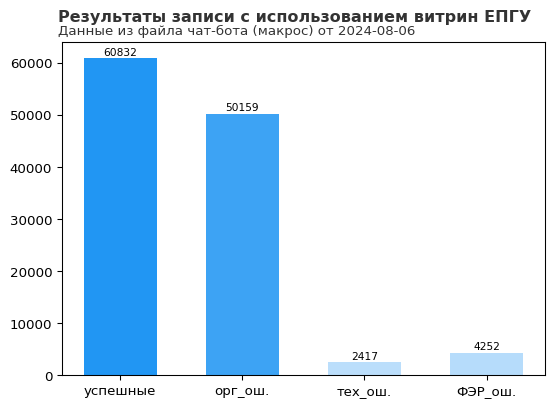

In [4]:
print(f"Файл чат-бота: {file_path}\n")
fig_date = file_path.split("_")[-1].split(".")[0]
df_dm = pd.read_excel(file_path, sheet_name="РФ", index_col=None, header=None)

df_dm_0 = df_dm.loc[[7, 11, 15, 19], [0, 1]]
df_dm_0[1] = df_dm_0[1].astype(int)
df_dm_0.at[7, 0] = "успешные"
df_dm_0.at[11, 0] = "орг_ош."
df_dm_0.at[15, 0] = "тех_ош."
df_dm_0.at[19, 0] = "ФЭР_ош."

fig, ax = plt.subplots(figsize=(6.5, 4.5), dpi=96)

bar1 = ax.bar(df_dm_0[0], df_dm_0[1], width=0.3)
ax.bar_label(bar1, labels=[e for e in df_dm_0[1]], padding=1, color="black", fontsize=8)

ax.text(
    x=0.12,
    y=0.93,
    s="Результаты записи с использованием витрин ЕПГУ",
    transform=fig.transFigure,
    ha="left",
    fontsize=12,
    weight="bold",
    alpha=0.8,
)
ax.text(
    x=0.12,
    y=0.90,
    s=f"Данные из файла чат-бота (макрос) от {fig_date}",
    transform=fig.transFigure,
    ha="left",
    fontsize=10,
    alpha=0.8,
)

colours = ["#bbdefb", "#2196f3"]

cmap = mpl.colors.LinearSegmentedColormap.from_list("colour_map", colours, N=256)
norm = mpl.colors.Normalize(
    df_dm_0[1].min(), df_dm_0[1].max()
)  # linearly normalizes data into the [0.0, 1.0] interval

bar1 = ax.bar(df_dm_0[0], df_dm_0[1], color=cmap(norm(df_dm_0[1])), width=0.6, zorder=2)

fig.savefig("C:/work/new_bot/img_to_channel/7.png", dpi=150)

# Отправка отчёта в канал 'Чат-ботим Запись к врачу' (и тестовая рассылка)   
### Серёжа, шо б ты сдох, откорректируй таки **дату** и **канал**!

In [6]:
report_text = "2024-08-06 - соответствует"

chat_id = "-1001952868172"  # Чат-ботим запись ко врачу
# chat_id = "1236685176" # @SV1stBOTtestBot

TOKEN = "6171322173:AAFHeWDbAC7uKiByFVauWt6lA-anNTuXH9U"  # @SV1stBOTtestBot
bot = telebot.TeleBot(TOKEN)
report_parh = "C:/work/new_bot/img_to_channel/"
report_list = os.listdir(report_parh)
report_list = [x for x in report_list if x.split(".")[-1] == "png"]

# bot.delete_message(chat_id, 3066)

if len(report_list) == 7:
    i1 = open(report_parh + report_list[0], "rb")
    i2 = open(report_parh + report_list[1], "rb")
    i3 = open(report_parh + report_list[2], "rb")
    i4 = open(report_parh + report_list[3], "rb")
    i5 = open(report_parh + report_list[4], "rb")
    i6 = open(report_parh + report_list[5], "rb")
    i7 = open(report_parh + report_list[6], "rb")

    bot.send_media_group(
        chat_id,
        [
            telebot.types.InputMediaPhoto(i1, caption=report_text),
            telebot.types.InputMediaPhoto(i2),
            telebot.types.InputMediaPhoto(i3),
            telebot.types.InputMediaPhoto(i4),
            telebot.types.InputMediaPhoto(i5),
            telebot.types.InputMediaPhoto(i6),
            telebot.types.InputMediaPhoto(i7),
        ],
    )
else:
    print("Должно быть 7 картинок")

# в Word
doc = aw.Document()
# print(doc)
builder = aw.DocumentBuilder(doc)
# builder.writeln(report_text)
builder.insert_image(i1)
builder.insert_image(i2)
builder.insert_image(i3)
builder.insert_image(i4)
builder.insert_image(i5)
builder.insert_image(i6)
builder.insert_image(i7)
# doc_save_path = "C:/Users/Admin/Desktop/отчёт" + "_" + report_text.split(" ")[0] + ".docx"
doc_save_path = (
    "C:/work/new_bot/img_to_channel/report_" + report_text.split(" ")[0] + ".docx"
)
# doc.save("C:/Users/Admin/Desktop/отчёт.docx")
doc.save(doc_save_path)
# print("save")

i1.close()
i2.close()
i3.close()
i4.close()
i5.close()
i6.close()
i7.close()

# Отправка федерального сообщения в 'Чат-бот КЦ МЗ РФ' (и тестовая рассылка)

In [7]:
TOKEN = "6171322173:AAFHeWDbAC7uKiByFVauWt6lA-anNTuXH9U"  # @SV1stBOTtestBot
bot = telebot.TeleBot(TOKEN)


def send_message(chat_id, img_path, text_message):
    """отправление сообщения"""
    with open(img_path, "rb") as photo:
        bot.send_photo(chat_id, photo, caption=text_message, parse_mode="Markdown")


def send_file(chat_id, file_send_path):
    """отправление файла"""
    f = open(file_send_path, "rb")
    bot.send_document(chat_id, f)
    f.close()

In [8]:
# ТЕСТОВАЯ РАССЫЛКА
chat_id = "1236685176"  # @SV1stBOTtestBot

send_message(chat_id, img1_path, message_list[0])
send_message(chat_id, img2_path, message_list[1])
send_message(chat_id, img3_path, message_list[2])
send_file(chat_id, file_send_path)

In [9]:
# СОБСТВЕННО РАССЫЛКА

chat_id = "-1001703020082"  # Чат-бот КЦ МЗ РФ

send_message(chat_id, img1_path, message_list[0])
send_message(chat_id, img2_path, message_list[1])
send_message(chat_id, img3_path, message_list[2])
send_file(chat_id, file_send_path)

# Выгрузки ПОС

In [45]:
etalon_columns_list = [
    "Номер",
    "Источник",
    "Верхнеуровневый ЛКО",
    "Категория",
    "Подкатегория",
    "Факт",
    "Организация, в которую поступило сообщение",
    "Организация, в которой находится сообщение",
    "Дата поступления",
    "Дата планируемого завершения работ",
    "Дата фактического завершения работ",
    "Стадия",
    "Статус",
    "Просрочено",
    "Фаст-трек",
    "ФЗ",
    "Тип решения",
    "Направлено по email в ФОИВ, не подключенный к ПОС",
    "Оценка ответа заявителем",
    "Повторное рассмотрение",
    "Организация координатора",
    "ФИО координатора",
    "Организация исполнителя",
    "ФИО исполнителя",
    "Организация руководителя",
    "ФИО руководителя",
]
df_pos_ref_reg = pd.read_csv(pos_reg_ref_path, sep=";")

df_pos = pd.DataFrame()

for file in pos_dir_last:
    df_pos_tmp = pd.read_excel(
        pos_path + "/" + max(os.listdir(pos_path)) + "/" + file,
        sheet_name="Sheet0",
        index_col=None,
    )

    print(f"Прочитан файл '{file}'")

    t = (
        "число столбцов верное"
        if df_pos_tmp.shape[1] == 26
        else "СТОЛБЦОВ " + str(df_pos_tmp.shape[1])
    )

    tmp_columns_list = list(df_pos_tmp.columns)
    res = [
        x
        for x in etalon_columns_list + tmp_columns_list
        if x not in etalon_columns_list or x not in tmp_columns_list
    ]

    r = "названия столбцов верные" if not res else "названия столбцов НЕ ВЕРНЫЕ"

    print(f"\t{t}\n\t{r}")

    if t == "число столбцов верное" and r == "названия столбцов верные":
        df_pos_tmp["Дата поступления"] = pd.to_datetime(df_pos_tmp["Дата поступления"], format="%d.%m.%Y")
        df_pos = pd.concat([df_pos, df_pos_tmp])
        print(f"\tфайл '{file}' присоединён")
        d_min = df_pos_tmp["Дата поступления"].min().strftime("%Y-%m-%d")
        d_max = df_pos_tmp["Дата поступления"].max().strftime("%Y-%m-%d")
        print(f"\tпериод с {d_min} по {d_max}\n")
    else:
        print(f"\tфайл '{file}' ПРОПУЩЕН\n")


df_pos.reset_index(drop=True, inplace=True)

df_pos["Дата фактического завершения работ"] = df_pos[
    "Дата фактического завершения работ"
].str.replace("-", "")

# df_pos["Дата поступления"] = pd.to_datetime(df_pos["Дата поступления"], format="%d.%m.%Y")

df_pos["Дата планируемого завершения работ"] = pd.to_datetime(
    df_pos["Дата планируемого завершения работ"], format="%d.%m.%Y"
)

df_pos["Дата фактического завершения работ"] = pd.to_datetime(
    df_pos["Дата фактического завершения работ"], format="%d.%m.%Y"
)

df_pos_act_reg = pd.DataFrame(df_pos["Верхнеуровневый ЛКО"].unique()).rename(
    columns={0: "actual_reg_name"}
)

df_reg_pos_contrast = df_pos_act_reg.merge(
    df_pos_ref_reg, left_on="actual_reg_name", right_on="pos_reg_name", how="left"
)

no_regnames = df_reg_pos_contrast[df_reg_pos_contrast["pos_reg_name"].isnull()][
    "actual_reg_name"
].tolist()

print(
    f"Отсутствуют в актуальном списке регионов для расчёта рассылки ({pos_reg_ref_path}):\n---------------------------------------------------------"
)

for name in no_regnames:
    print(name)
print("\n")

d_min = df_pos["Дата поступления"].min().strftime("%Y-%m-%d")
d_max = df_pos["Дата поступления"].max().strftime("%Y-%m-%d")

# проверка на "_"
# badsim(df_pos, "_")

# сверка с файлом чат-бота (не справочником, а самим файлом)

# из файла чат-бота
pos_bot_files_path = "/".join(pos_path.split("/")[:3])+"/"
pos_bot_list = os.listdir(pos_bot_files_path)
pos_bot_list = [x for x in pos_bot_list if x.split(".")[-1] == "xlsm"]
pos_bot_path = pos_bot_files_path + max(pos_bot_list)
df_pos_reg_names_bot = pd.read_excel(
        pos_bot_path,
        sheet_name="Население",
        index_col=None,
    )

# из последних исходников
df_pos_reg_names = pd.DataFrame(df_pos["Верхнеуровневый ЛКО"].unique())

df_pos_reg_names_test = df_pos_reg_names.merge(df_pos_reg_names_bot, left_on=0, right_on="Unnamed: 3", how="left")

df_pos_reg_names_test = (
    pd.DataFrame(
        df_pos_reg_names_test[[0, "Unnamed: 3"]][
            df_pos_reg_names_test["Unnamed: 3"].isna()
        ][0]
    )
    .reset_index(drop=True)
    .rename(columns={0: "Отсутствуют в последнем файле чат-бота:"})
)

print(f"Последний файл чат-бота: {pos_bot_path}")
print(tabulate(df_pos_reg_names_test, showindex=False, headers=df_pos_reg_names_test.columns))

print(f"\nПериод с {d_min} по {d_max}")

Прочитан файл 'Выгрузка ПОС с 01.03.2023 по 31.05.2023.xlsx'
	число столбцов верное
	названия столбцов верные
	файл 'Выгрузка ПОС с 01.03.2023 по 31.05.2023.xlsx' присоединён
	период с 2023-03-01 по 2023-05-31

Прочитан файл 'Выгрузка ПОС с 01.06.2023 по 31.08.2023.xlsx'
	число столбцов верное
	названия столбцов верные
	файл 'Выгрузка ПОС с 01.06.2023 по 31.08.2023.xlsx' присоединён
	период с 2023-06-01 по 2023-08-31

Прочитан файл 'Выгрузка ПОС с 01.09.2023 по 22.11.2023.xlsx'
	число столбцов верное
	названия столбцов верные
	файл 'Выгрузка ПОС с 01.09.2023 по 22.11.2023.xlsx' присоединён
	период с 2023-09-01 по 2023-11-22

Прочитан файл 'Выгрузка ПОС с 11.11.2022 по 28.02.2023.xlsx'
	число столбцов верное
	названия столбцов верные
	файл 'Выгрузка ПОС с 11.11.2022 по 28.02.2023.xlsx' присоединён
	период с 2022-11-11 по 2023-02-28

Прочитан файл 'Выгрузка ПОС с 13.05.2024 по 06.08.2024.xlsx'
	число столбцов верное
	названия столбцов верные
	файл 'Выгрузка ПОС с 13.05.2024 по 06.08.2024

In [44]:
pos_dir_last

['Выгрузка ПОС с 01.03.2023 по 31.05.2023.xlsx',
 'Выгрузка ПОС с 01.06.2023 по 31.08.2023.xlsx',
 'Выгрузка ПОС с 01.09.2023 по 22.11.2023.xlsx',
 'Выгрузка ПОС с 11.11.2022 по 28.02.2023.xlsx',
 'Выгрузка ПОС с 13.05.2024 по 06.08.2024.xlsx',
 'Выгрузка ПОС с 21.02.2024 по 12.05.2024.xlsx',
 'Выгрузка ПОС с 23.11.2023 по 20.02.2024.xlsx']

In [28]:
df_pos_test = df_pos.copy()
df_pos_test["Дата поступления"] = pd.to_datetime(df_pos_test["Дата поступления"], format="%d.%m.%Y")
d_min = df_pos_test["Дата поступления"].min().strftime("%Y-%m-%d")
d_max = df_pos_test["Дата поступления"].max().strftime("%Y-%m-%d")
print(f"Период с {d_min} по {d_max}")

Период с 2022-11-11 по 2024-07-29


In [29]:
df_pos.sort_values("Дата поступления")

,Номер,Источник,Верхнеуровневый ЛКО,Категория,Подкатегория,Факт,"Организация, в которую поступило сообщение","Организация, в которой находится сообщение",Дата поступления,Дата планируемого завершения работ,...,Тип решения,"Направлено по email в ФОИВ, не подключенный к ПОС",Оценка ответа заявителем,Повторное рассмотрение,Организация координатора,ФИО координатора,Организация исполнителя,ФИО исполнителя,Организация руководителя,ФИО руководителя
593593,177130926,ЕПГУ,Чеченская Республика,Электронная запись на прием к врачу,Проблемы с выбором медицинского специалиста,Не отображаются нужные специальности врача для...,МЗЧР,"ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ""ВРАЧЕБНО...",2022-11-11,2022-11-13,...,Решено,-,-,-,"ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ""ВРАЧЕБНО...",Хасуева Фатима Богдановна,"ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ""ВРАЧЕБНО...",Хасуева Фатима Богдановна,"ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ""ВРАЧЕБНО...",Хасуева Фатима Богдановна
594568,177134680,ЕПГУ,Мурманская область,Электронная запись на прием к врачу,Проблемы с выбором временного слота для записи,Другое,МИНИСТЕРСТВО ЗДРАВООХРАНЕНИЯ МУРМАНСКОЙ ОБЛАСТИ,"ГОБУЗ ""АПАТИТСКО-КИРОВСКАЯ ЦЕНТРАЛЬНАЯ ГОРОДСК...",2022-11-11,2022-11-14,...,Решено,-,-,-,ГОСУДАРСТВЕННОЕ ОБЛАСТНОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ...,Яковлева Ирина Александровна,ГОСУДАРСТВЕННОЕ ОБЛАСТНОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ...,Яковлева Ирина Александровна,ГОСУДАРСТВЕННОЕ ОБЛАСТНОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ...,Яковлева Ирина Александровна
594567,177134665,ЕПГУ,Республика Коми,Электронная запись на прием к врачу,Проблемы с выбором медицинского специалиста,Не отображаются нужные специальности врача для...,МИНИСТЕРСТВО ЗДРАВООХРАНЕНИЯ РЕСПУБЛИКИ КОМИ,ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХР...,2022-11-11,2022-11-18,...,Решено,-,2,2,ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХР...,Манина Ольга Игоревна,ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХР...,Манина Ольга Игоревна,ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХР...,Манина Ольга Игоревна
594566,177134664,Сайт,г. Санкт-Петербург,Электронная запись на прием к врачу,Проблемы с выбором временного слота для записи,-,КОМИТЕТ ПО ЗДРАВООХРАНЕНИЮ САНКТ-ПЕТЕРБУРГА,САНКТ-ПЕТЕРБУРГСКОЕ ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ ...,2022-11-11,2022-11-14,...,Решено,-,-,-,САНКТ-ПЕТЕРБУРГСКОЕ ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ ...,Васильева Юлия Вадимовна,САНКТ-ПЕТЕРБУРГСКОЕ ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ ...,Васильева Юлия Вадимовна,САНКТ-ПЕТЕРБУРГСКОЕ ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ ...,Сокиркина Людмила Дмитриевна
594565,177134663,ЕПГУ,Белгородская область,Электронная запись на прием к врачу,Проблемы с выбором медицинского специалиста,Нет конкретного ФИО специалиста (лечащего врач...,МИНИСТЕРСТВО ЗДРАВООХРАНЕНИЯ БЕЛГОРОДСКОЙ ОБЛАСТИ,МИНИСТЕРСТВО ЗДРАВООХРАНЕНИЯ БЕЛГОРОДСКОЙ ОБЛАСТИ,2022-11-11,2022-11-14,...,Решено,-,-,-,Данные отсутствуют (СЭД),Данные отсутствуют (СЭД),Данные отсутствуют (СЭД),Данные отсутствуют (СЭД),Данные отсутствуют (СЭД),Данные отсутствуют (СЭД)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
954290,224375321,ЕПГУ,Ханты-Мансийский автономный округ - Югра,Электронная запись на прием к врачу,Проблемы с выбором медицинского специалиста,Не отображаются нужные специальности врача для...,ДЕПЗДРАВ ЮГРЫ,"БУ ""НИЖНЕВАРТОВСКАЯ РАЙОННАЯ БОЛЬНИЦА""",2024-07-29,2024-08-01,...,Решено,-,-,-,БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ХАНТЫ-МАНСИЙСКОГО АВТОНОМ...,Зеленина Эльвира Зуфаровна,БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ХАНТЫ-МАНСИЙСКОГО АВТОНОМ...,Зеленина Эльвира Зуфаровна,БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ХАНТЫ-МАНСИЙСКОГО АВТОНОМ...,Шляхтина Нина Анатольевна
954289,224375315,ЕПГУ,Алтайский край,Электронная запись на прием к врачу,Проблемы с выбором региона при записи,Другое,Минздрав АК,"КГБУЗ ""АКМИАЦ""",2024-07-29,2024-08-01,...,-,-,-,-,-,NaN,-,NaN,-,NaN
954288,224375281,ЕПГУ,Правительство Челябинской области,Электронная запись на прием к врачу,Проблемы с выбором медицинского специалиста,Не отображаются нужные специальности врача для...,Министерство здравоохранения Челябинской области,"ГБУЗ ""СП № 2 Г. МАГНИТОГОР

In [30]:
df_pos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1361048 entries, 0 to 1361047
Data columns (total 26 columns):
 #   Column                                             Non-Null Count    Dtype         
---  ------                                             --------------    -----         
 0   Номер                                              1361048 non-null  int64         
 1   Источник                                           1361048 non-null  object        
 2   Верхнеуровневый ЛКО                                1361048 non-null  object        
 3   Категория                                          1361048 non-null  object        
 4   Подкатегория                                       1361048 non-null  object        
 5   Факт                                               1361048 non-null  object        
 6   Организация, в которую поступило сообщение         1361048 non-null  object        
 7   Организация, в которой находится сообщение         1361048 non-null  object      

***

### **Ситуативная сверка с дашбордом**

In [25]:
# загрузка данных из БД38
df_db38 = pd.read_excel(
    "C:/work/comparison_error_successful/db_data/db_data.xlsx",
    sheet_name="1",
    index_col=None,
).fillna(0)
df_db38["b"] = df_db38["b"].astype("int")
df_db38.insert(
    2, "end_date", df_db38["begin_date"].apply(lambda x: x + timedelta(days=6))
)
df_db38 = df_db38.drop("per", axis=1)
df_db38["date_interval"] = df_db38.apply(
    lambda x: x["begin_date"].strftime("%Y-%m-%d")
    + "_"
    + x["end_date"].strftime("%Y-%m-%d"),
    axis=1,
)
df_db38_group = (
    df_db38[["date_interval", "s", "d", "o", "t", "b", "r"]]
    .groupby("date_interval")
    .sum()
    .reset_index()
)
df_db38_group

,date_interval,s,d,o,t,b,r
0,2022-08-22_2022-08-28,392934,1490942,522569,476508,0,98630
1,2022-08-29_2022-09-04,406878,1477808,495559,453596,0,60952
2,2022-09-05_2022-09-11,440400,1654386,531767,501942,0,110253
3,2022-09-12_2022-09-18,448675,1696666,530951,618780,0,107420
4,2022-09-19_2022-09-25,446461,1615018,509438,547847,0,115686
...,...,...,...,...,...,...,...
70,2023-12-25_2023-12-31,381976,1308565,139095,179895,29540,80668
71,2024-01-01_2024-01-07,396916,950536,87188,113438,21488,55825
72,2024-01-08_2024-01-14,917724,2188512,256120,297006,65811,143633
73,2024-01-15_2024-01-21,872500,2282921,241923,292696,64892,156722


In [26]:
# то же по регионам
df_db38_group_region = (
    df_db38[["region", "s", "d", "o", "t", "b", "r", "date_interval"]]
    .groupby(["region", "date_interval"])
    .sum()
    .reset_index()
)
df_db38_group_region

,region,date_interval,s,d,o,t,b,r
0,Алтайский край,2022-08-22_2022-08-28,15602,100274,5641,4456,0,2645
1,Алтайский край,2022-08-29_2022-09-04,15180,92615,5731,4043,0,2190
2,Алтайский край,2022-09-05_2022-09-11,16444,100234,6523,5214,0,6608
3,Алтайский край,2022-09-12_2022-09-18,15700,105435,6513,20883,0,4115
4,Алтайский край,2022-09-19_2022-09-25,16358,93605,5539,3499,0,7946
...,...,...,...,...,...,...,...,...
6370,г. Севастополь,2023-12-25_2023-12-31,3640,18329,1236,565,187,1103
6371,г. Севастополь,2024-01-01_2024-01-07,6013,14256,223,272,269,720
6372,г. Севастополь,2024-01-08_2024-01-14,9398,25002,471,573,769,1316
6373,г. Севастополь,2024-01-15_2024-01-21,9313,30516,643,447,688,1727


In [27]:
# загрузка из выгрузки дашборда
df_dash = pd.read_excel(
    "C:/work/comparison_error_successful/db_data/dash_data.xlsx",
    sheet_name="1",
    index_col=None,
)
df_dash["date"] = pd.to_datetime(df_dash["date"], format="%Y-%m-%d")
df_dash = df_dash.sort_values("date")

# добавление столбца с интервалами по 7 дней
df_dash_int = pd.DataFrame()
for i in range(0, df_dash.shape[0] // 7 * 7, 7):
    index_list = [x for x in range(i, i + 7)]
    df_tmp = df_dash.iloc[index_list]
    date_begin = df_tmp["date"].min()
    date_end = df_tmp["date"].max()
    date_interval = (
        date_begin.strftime("%Y-%m-%d") + "_" + date_end.strftime("%Y-%m-%d")
    )
    df_tmp["date_interval"] = date_interval
    df_dash_int = pd.concat([df_dash_int, df_tmp])

df_dash_group = (
    df_dash_int[["date_interval", "o_d", "r_d", "t_d", "s_d"]]
    .groupby("date_interval")
    .sum()
    .reset_index()
)
df_dash_group

,date_interval,o_d,r_d,t_d,s_d
0,2022-08-22_2022-08-28,522569,98922,478559,396534
1,2022-08-29_2022-09-04,495559,61014,456852,406878
2,2022-09-05_2022-09-11,531768,110396,505355,440400
3,2022-09-12_2022-09-18,531423,107755,624034,448675
4,2022-09-19_2022-09-25,510189,115942,555194,446461
...,...,...,...,...,...
70,2023-12-25_2023-12-31,139095,80671,173974,381976
71,2024-01-01_2024-01-07,87188,55828,109347,396916
72,2024-01-08_2024-01-14,256120,143636,287987,917724
73,2024-01-15_2024-01-21,241923,156727,282077,872500


In [30]:
# объединение и расчёт расхождений
df_test = df_dash_group.merge(
    df_db38_group[["date_interval", "o", "r", "t", "s"]],
    on="date_interval",
    how="outer",
)
df_test = df_test[["date_interval", "s_d", "s", "o_d", "o", "t_d", "t", "r_d", "r"]]
df_test.insert(3, "Δs", df_test["s_d"] - df_test["s"])
df_test.insert(6, "Δo", df_test["o_d"] - df_test["o"])
df_test.insert(9, "Δt", df_test["t_d"] - df_test["t"])
df_test["Δr"] = df_test["r_d"] - df_test["r"]
df_test

,date_interval,s_d,s,Δs,o_d,o,Δo,t_d,t,Δt,r_d,r,Δr
0,2022-08-22_2022-08-28,396534,392934,3600,522569,522569,0,478559,476508,2051,98922,98630,292
1,2022-08-29_2022-09-04,406878,406878,0,495559,495559,0,456852,453596,3256,61014,60952,62
2,2022-09-05_2022-09-11,440400,440400,0,531768,531767,1,505355,501942,3413,110396,110253,143
3,2022-09-12_2022-09-18,448675,448675,0,531423,530951,472,624034,618780,5254,107755,107420,335
4,2022-09-19_2022-09-25,446461,446461,0,510189,509438,751,555194,547847,7347,115942,115686,256
...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,2023-12-25_2023-12-31,381976,381976,0,139095,139095,0,173974,179895,-5921,80671,80668,3
71,2024-01-01_2024-01-07,396916,396916,0,87188,87188,0,109347,113438,-4091,55828,55825,3
72,2024-01-08_2024-01-14,917724,917724,0,256120,256120,0,287987,297006,-9019,143636,143633,3
73,2024-01-15_2024-01-21,872500,872500,0,241923,241923,0,282077,292696,-10619,156727,156722,5


In [37]:
# загрузка моей предрасчитанной статистики с 6 ноября по 31 декабря
# без Байконура и ФМБА, но с Кемской волостью

stat_11_12_path = "C:/work/comparison_error_successful/data_11_12/data_11-12_weeks.csv"

df_stat_11_12 = pd.read_csv(stat_11_12_path, sep=";")
# без Кемской волости
df_stat_11_12 = df_stat_11_12[df_stat_11_12["real_region_name"] != "Кемская волость"]


df_stat_11_12["date"] = pd.to_datetime(df_stat_11_12["date"], format="%d.%m.%Y")


df_stat_11_12_p = (
    pd.pivot_table(
        df_stat_11_12, index="date", columns="type", values="value", aggfunc="sum"
    )
    .reset_index()
    .rename_axis(None, axis=1)
)

df_stat_11_12_int = pd.DataFrame()
for i in range(0, df_stat_11_12_p.shape[0] // 7 * 7, 7):
    index_list = [x for x in range(i, i + 7)]
    df_tmp = df_stat_11_12_p.iloc[index_list]
    date_begin = df_tmp["date"].min()
    date_end = df_tmp["date"].max()
    date_interval = (
        date_begin.strftime("%Y-%m-%d") + "_" + date_end.strftime("%Y-%m-%d")
    )
    df_tmp["date_interval"] = date_interval
    df_stat_11_12_int = pd.concat([df_stat_11_12_int, df_tmp])
df_stat_11_12_int = df_stat_11_12_int.rename(
    columns={
        "Организационные ошибки": "o_my",
        "Ошибки ФЭР": "r_my",
        "Технические ошибки": "t_my",
        "Успешные записи": "s_my",
        "Черновики": "d_my",
    }
)
df_stat_11_12_group = (
    df_stat_11_12_int[["date_interval", "o_my", "r_my", "t_my", "s_my", "d_my"]]
    .groupby("date_interval")
    .sum()
)
df_stat_11_12_group = df_stat_11_12_group[
    ["s_my", "o_my", "t_my", "r_my"]
].reset_index()
df_stat_11_12_group

,date_interval,s_my,o_my,t_my,r_my
0,2023-11-06_2023-11-12,779713,282955,325562,158005
1,2023-11-13_2023-11-19,806094,269930,333416,207319
2,2023-11-20_2023-11-26,838960,284453,453286,167827
3,2023-11-27_2023-12-03,878490,290400,430188,168240
4,2023-12-04_2023-12-10,830193,250524,462139,138220
5,2023-12-11_2023-12-17,816697,197996,409735,143082
6,2023-12-18_2023-12-24,592523,207482,250561,120517
7,2023-12-25_2023-12-31,381976,139095,179895,80668


In [35]:
df_stat_11_12[df_stat_11_12["real_region_name"] == "Кемская волость"][["type", "value"]].groupby("type").sum()

,value
type,
Организационные ошибки,0
Ошибки ФЭР,29
Технические ошибки,0
Успешные записи,0
Черновики,0


***

### Сводные результаты за неделю

In [49]:
ew_path = "C:/work/morev/mk_ref/error"
sw_path = "C:/work/morev/mk_ref/succsessful"
dmw_path = "C:/work/morev/mk_ref/dm"

def concat(path, sheet_name):
    """функция невозбранно конкатенирует и возвращает"""
    df_def = pd.DataFrame()
    file_list = os.listdir(path)
    for file_name in file_list:
        df_tmp = pd.read_excel(path + "/" + file_name, sheet_name=sheet_name, index_col=None)
        df_def = pd.concat([df_def, df_tmp])
        print(path + "/" + file_name)
    return df_def

In [62]:
# ошибки
df_ew = concat(ew_path, "1")
df_ew3 = df_ew[df_ew["Тип записи"] == 3].reset_index(drop=True)
# субъекты
df_reg = (
    pd.DataFrame(df_ew["Название субъекта РФ"])
    .drop_duplicates()
    .sort_values(by="Название субъекта РФ")
    .reset_index(drop=True)
)
# технические ошибки
df_t = df_ew3[df_ew3["final_state"].isin(t_error_list)]
df_t = (
    pd.DataFrame(df_t.groupby("Название субъекта РФ")["final_state"].count())
    .reset_index()
    .rename(columns={"final_state": "t"})
)
df_t["t"] = df_t["t"].astype(int)
# организационные ошибки
df_o = df_ew3[df_ew3["final_state"].isin(o_error_list)]
df_o = (
    pd.DataFrame(df_o.groupby("Название субъекта РФ")["final_state"].count())
    .reset_index()
    .rename(columns={"final_state": "o"})
)
df_o["o"] = df_o["o"].astype(int)
# ошибки фэр
df_r = df_ew3[df_ew3["final_state"].isin(r_error_list)]
df_r = (
    pd.DataFrame(df_r.groupby("Название субъекта РФ")["final_state"].count())
    .reset_index()
    .rename(columns={"final_state": "r"})
)
df_r["r"] = df_r["r"].astype(int)
# прочие ошибки
df_a = df_ew3[df_ew3["final_state"].isin(any_error_list)]
df_a = (
    pd.DataFrame(df_a.groupby("Название субъекта РФ")["final_state"].count())
    .reset_index()
    .rename(columns={"final_state": "a"})
)
df_a["a"] = df_a["a"].astype(int)
# бизнес-правила
df_b = df_ew3[df_ew3["final_state"].isin(b_list)]
df_b = (
    pd.DataFrame(df_b.groupby("Название субъекта РФ")["final_state"].count())
    .reset_index()
    .rename(columns={"final_state": "b"})
)
df_b["b"] = df_b["b"].astype(int)
# черновики
df_d = df_ew3[df_ew3["final_state"].isin(draft_list)]
df_d = (
    pd.DataFrame(df_d.groupby("Название субъекта РФ")["final_state"].count())
    .reset_index()
    .rename(columns={"final_state": "d"})
)
df_d["d"] = df_d["d"].astype(int)

df_error = (
    df_reg.merge(df_t, on="Название субъекта РФ", how="outer")
    .merge(df_o, on="Название субъекта РФ", how="outer")
    .merge(df_r, on="Название субъекта РФ", how="outer")
    .merge(df_a, on="Название субъекта РФ", how="outer")
    .merge(df_b, on="Название субъекта РФ", how="outer")
    .merge(df_d, on="Название субъекта РФ", how="outer")
)
df_error = df_error.fillna(0)
df_error = df_error.astype(
    {"t": "int", "o": "int", "r": "int", "a": "int", "b": "int", "d": "int"}
)
#успешники
df_sw = concat(sw_path, "1")
df_sw3 = df_sw[df_sw["Тип записи"] == 3]
df_sucs = pd.DataFrame(df_sw3.groupby("Название субъекта РФ")["session_id"].count()).sort_values(by="Название субъекта РФ").reset_index().rename(columns={"session_id": "s"})

# КУ!
df_ku = df_error.merge(df_sucs, on="Название субъекта РФ", how="outer").fillna(0)
df_ku["s"] = df_ku["s"].astype(int)
df_ku

C:/work/morev/mk_ref/error/01.05.2024.xlsx
C:/work/morev/mk_ref/error/02.05.2024.xlsx
C:/work/morev/mk_ref/error/03.05.2024.xlsx
C:/work/morev/mk_ref/error/04.05.2024.xlsx
C:/work/morev/mk_ref/error/05.05.2024.xlsx
C:/work/morev/mk_ref/error/29.04.2024.xlsx
C:/work/morev/mk_ref/error/30.04.2024.xlsx
C:/work/morev/mk_ref/succsessful/И38_успешные_сессии_20240429.xlsx
C:/work/morev/mk_ref/succsessful/И38_успешные_сессии_20240430.xlsx
C:/work/morev/mk_ref/succsessful/И38_успешные_сессии_20240501.xlsx
C:/work/morev/mk_ref/succsessful/И38_успешные_сессии_20240502.xlsx
C:/work/morev/mk_ref/succsessful/И38_успешные_сессии_20240503.xlsx
C:/work/morev/mk_ref/succsessful/И38_успешные_сессии_20240504.xlsx
C:/work/morev/mk_ref/succsessful/И38_успешные_сессии_20240505.xlsx


,Название субъекта РФ,t,o,r,a,b,d,s
0,Алтайский край,6792,1296,3760,0,121,102781,22629
1,Амурская область,715,18,68,0,325,10239,3195
2,Архангельская область,824,4607,2974,0,265,64485,11121
3,Астраханская область,32,110,78,0,21,492,114
4,Белгородская область,213,110,2822,0,273,7588,2795
...,...,...,...,...,...,...,...,...
81,Ямало-Ненецкий автономный округ,17,2,1,0,0,4,0
82,Ярославская область,931,6999,2101,0,232,12008,6256
83,г. Москва,18559,3394,455,0,0,35337,8644
84,г. Санкт-Петербург,12576,5475,7420,0,905,46177,12688


In [63]:
ku_save_path = "C:/work/morev/mk_ref/kufer.csv"
df_ku.to_csv(ku_save_path, sep=";", encoding="utf-8-sig", index=False)